<a href="https://colab.research.google.com/github/diogo0030/computer-vision-classification-of-defects-in-photovoltaic-modules/blob/main/classification_of_defects_in_photovoltaic_modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identification**

* **Name:** Afonso Tomás de Magalhães Mateus
* **Student Number:** 202204126

* **Name:** Diogo Soares de Albergaria Oliveira
* **Student Number:** 202108325
---

# **Initial setup**

In [9]:
# Ver informação básica da GPU
!nvidia-smi
# Clonar o repo do dataset
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git

%cd InfraredSolarModules

!unzip 2020-02-14_InfraredSolarModules.zip


Wed Dec  3 17:50:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### **Library Imports**

In [10]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from tqdm import tqdm



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.metrics import confusion_matrix, classification_report

###Dataset Loading and Initial Exploration
In this section we load and perform an initial exploration of the Infrared Solar Modules dataset provided by Raptor Maps. The dataset consists of infrared (IR) images of photovoltaic (PV) modules, each annotated with a single anomaly type. The annotation file module_metadata.json contains, for every sample, the relative image path (images/<id>.jpg) and the corresponding anomaly_class. We parse this JSON file into a Pandas DataFrame and add an absolute-path column to facilitate subsequent image loading and preprocessing.

In [11]:
data_dir = Path('/content/InfraredSolarModules/InfraredSolarModules')
meta_path = data_dir / 'module_metadata.json'

# Ler o JSON
with open(meta_path, 'r') as f:
    metadata = json.load(f)

# Convert the metadata dictionary to a DataFrame
df = pd.DataFrame.from_dict(metadata, orient='index')

df = df.rename(columns={'image_filepath': 'rel_path', 'anomaly_class': 'label'})

# Criar coluna com o caminho absoluto (Path)
df['path'] = df['rel_path'].apply(lambda p: data_dir / p)

df.head()

,rel_path,label,path
13357,images/13357.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...
13356,images/13356.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...
19719,images/19719.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...
11542,images/11542.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...
11543,images/11543.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...


###Pre-Processing
Before training our models, we apply a sharpening step to the original infrared images. The Infrared Solar Modules dataset consists of very low–resolution images (24×40 pixels), where defects such as hot-spots or cell cracking often appear as small, low-contrast structures. To enhance these structures, we use an unsharp mask filter, implemented via the PIL.ImageFilter.UnsharpMask function with radius = 2 and strength = 150%.

The unsharp mask computes a blurred version of the image, subtracts it from the original to obtain an “edge image”, and then adds a scaled version of these edges back to the original. Qualitatively, this increases the contrast of cell boundaries and defect regions, as illustrated in Figure (Effect of Unsharp Mask Preprocessing on IR Images).



In [12]:


def apply_unsharp(image, radius=2, percent=150, threshold=0):
    """
    Aplica o filtro UnsharpMask à imagem.
    radius   : raio do blur usado para extrair bordas (2 píxeis, como no artigo)
    percent  : força com que as bordas são somadas de volta (150%)
    threshold: ignora pequenas diferenças (0 = tudo conta)
    """
    return image.filter(ImageFilter.UnsharpMask(radius=radius,
                                               percent=percent,
                                               threshold=threshold))


/tmp/ipython-input-4215751933.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(1, random_state=42))


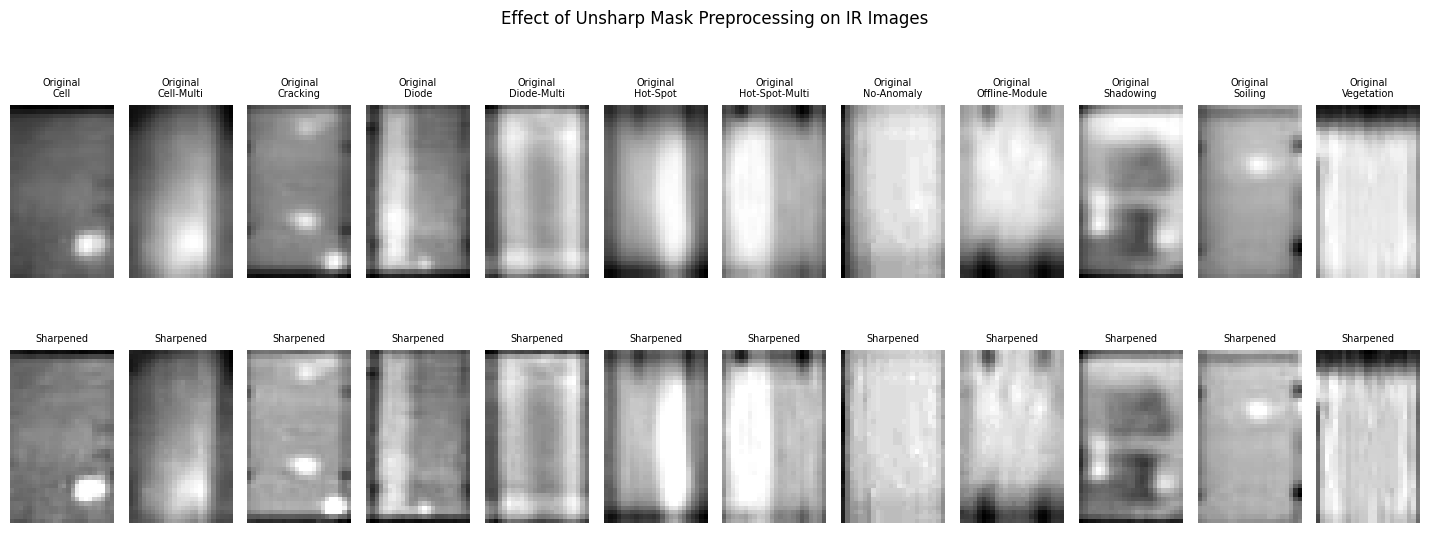

In [13]:
sample_df = (
    df.groupby('label', group_keys=False)
      .apply(lambda g: g.sample(1, random_state=42))
      .sort_values('label')            # opcional: ordena pelas classes
      .reset_index(drop=True)
)

num_samples = len(sample_df)

plt.figure(figsize=(1.2*num_samples, 6))

for i, (_, row) in enumerate(sample_df.iterrows()):
    img = Image.open(row['path'])
    sharp = apply_unsharp(img)

    # Linha 1: original
    plt.subplot(2, len(sample_df), i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{row['label']}", fontsize=7)
    plt.axis('off')

    # Linha 2: filtrada
    plt.subplot(2, len(sample_df), i+1+len(sample_df))
    plt.imshow(sharp, cmap='gray')
    plt.title("Sharpened", fontsize=7)
    plt.axis('off')

plt.suptitle('Effect of Unsharp Mask Preprocessing on IR Images', fontsize=12)
plt.tight_layout()
plt.show()

In [14]:
sharp_dir = data_dir / 'images_sharp'
sharp_dir.mkdir(exist_ok=True)

# Aplica o unsharp a TODAS as imagens e guarda em images_sharp/
for img_path in tqdm(df['path'], total=len(df)):
    img_path = Path(img_path)
    dst_path = sharp_dir / img_path.name  # mesmo nome, nova pasta

    # Se já existir, salta
    if dst_path.exists():
      continue

    img = Image.open(img_path)
    sharp = apply_unsharp(img)
    sharp.save(dst_path)

df['sharp_path'] = df['path'].apply(lambda p: sharp_dir / Path(p).name)
df.head()


100%|██████████| 20000/20000 [00:00<00:00, 56638.80it/s]


,rel_path,label,path,sharp_path
13357,images/13357.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...
13356,images/13356.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...
19719,images/19719.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...
11542,images/11542.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...
11543,images/11543.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...


###Data Augmentation

In [15]:
class_counts = df['label'].value_counts()
print(class_counts)

label
No-Anomaly        10000
Cell               1877
Vegetation         1639
Diode              1499
Cell-Multi         1288
Shadowing          1056
Cracking            940
Offline-Module      827
Hot-Spot            249
Hot-Spot-Multi      246
Soiling             204
Diode-Multi         175
Name: count, dtype: int64
